# Case study
Given a user’s past reviews on Yelp (available from yelp-challenge dataset),

When the user writes a review for a business she hasn't reviewed before,

How likely will it be a Five-Star review?

- Load data
- Visualize the data
- Featurize the data
- Join tables to populate the features
- Model the data: Logistic regression
- Evaluate the model
- Make prediction with the model

## Data source
[Yelp Dataset Round 13](https://www.yelp.com/dataset)

We took the full set of business, user, and review data in json format.


# Step 1: Load the Data

We store data in Pandas DataFrames.

We load three types of data from the dataset, each stored in a separate df.

`set_index()`: tells pandas to index the df by the column specified in the param.

In [1]:
%%time
import pandas as pd

CHUNK_SIZE = 10000
PATH = '~/Desktop/yelp_dataset/'

CPU times: user 407 ms, sys: 203 ms, total: 610 ms
Wall time: 1.77 s


In [2]:
%%time
review_df = pd.concat(pd.read_json(PATH + 'review.json', lines=True, chunksize=CHUNK_SIZE))
review_df = review_df.set_index('review_id')

CPU times: user 1min 26s, sys: 19.1 s, total: 1min 45s
Wall time: 1min 46s


In [3]:
%%time
user_df = pd.concat(pd.read_json(PATH + 'user.json', lines=True, chunksize=CHUNK_SIZE))
user_df = user_df.set_index('user_id')

CPU times: user 40.9 s, sys: 10.5 s, total: 51.4 s
Wall time: 50.9 s


In [4]:
%%time
biz_df = pd.concat(pd.read_json(PATH + 'business.json', lines=True, chunksize=CHUNK_SIZE))
biz_df = biz_df.set_index('business_id')

CPU times: user 5.84 s, sys: 1.05 s, total: 6.89 s
Wall time: 6.04 s


## Useful Functions to Explore the DataFrames
`review_df.head()`: Print top rows in the data frame.

`review_df.describe()`: Generate various summary statistics, mean, max, count, etc.

# Step 2: Explore & Visualize the Data

## Example 1: Plot Review Star Rating Distribution

First ask yourself this question: 

Among all the reviews available in the dataset, what percentage of them are 5 star? 

One common mis-conception about Yelp, is that folks only come to Yelp to complaint about their negative experiences with a business, so most of the reviews "should" be low rating. 

However, this is a misconception, according to the below graph we plot, using the Yelp Open Dataset.

In [49]:
import seaborn as sns
%matplotlib inline

# Set context to "talk" for figure aesthetics 
sns.set_context(context="talk")
# set plot figure size to larger
sns.set(palette='Set2', rc={"figure.figsize": (15, 8)}, style="ticks")

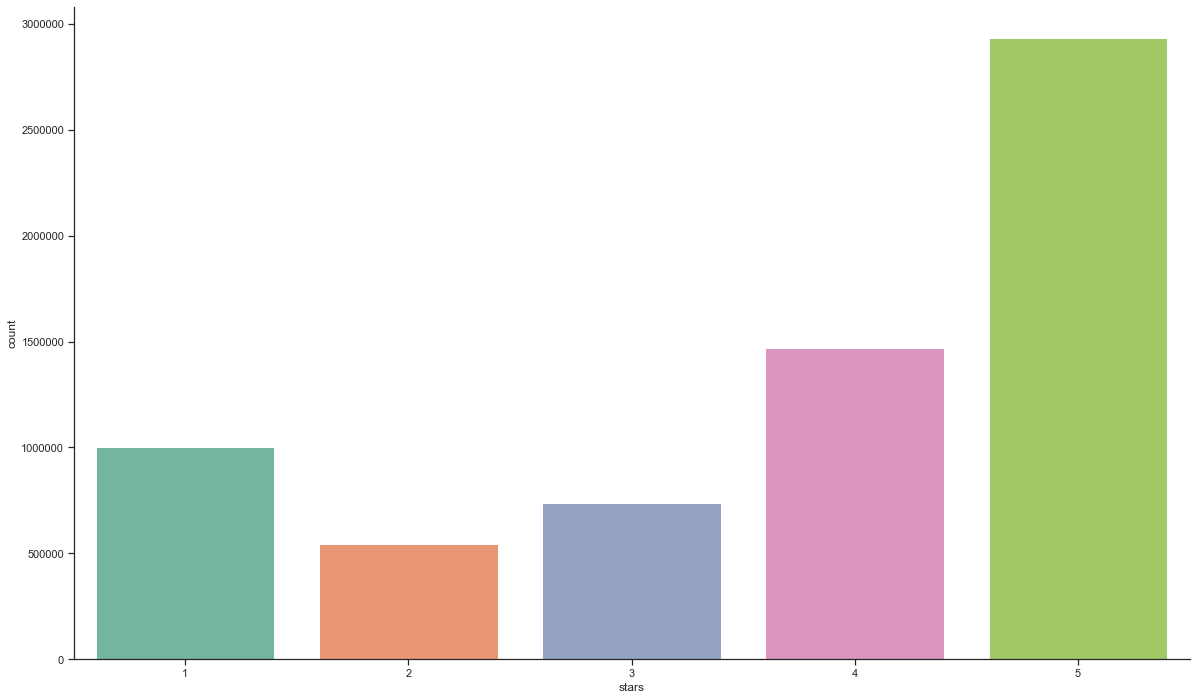

In [50]:
ax = sns.countplot(x='stars', data=review_df)
# Removing spines
sns.despine()

## Example 2: Plot Review Star Rating Distribution by year

From below graph,
- healthy growth over the years, on the amount of reviews people wrote every year. 
- later years, there seems to be a shift towards 5 star reviews. 

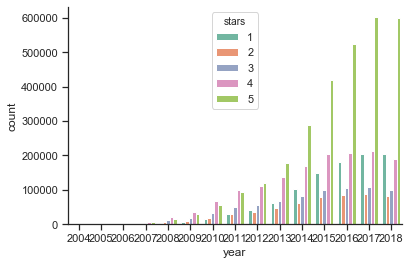

In [7]:
review_df['datetime'] = pd.to_datetime(review_df['date'])
review_df['year'] = review_df['datetime'].dt.year
ax = sns.countplot(x='year', data=review_df, hue='stars')
sns.despine()

# Step 3: Generate the Features

# 3.1 Examples Feature Extractions & Conversions

- Convert date string to date delta
  - For example, `business_age`
- Convert strings to categorical features
  - For example, `noise_level`: `{'quiet', 'loud', 'very loud'}`.
- Drop unused features
  - For example, `business_name`

In [8]:
def calculate_date_delta(df, from_column, to_column):
    datetime = pd.to_datetime(df[from_column])
    time_delta = datetime.max() - datetime
    df[to_column] = time_delta.apply(lambda x: x.days)
    df.drop(from_column, axis=1, inplace=True)

In [9]:
def to_length(df, from_column, to_column):
    df[to_column] = df[from_column].apply(lambda x: len(x))
    df.drop(from_column, axis=1, inplace=True)

In [10]:
def drop_columns(df, columns):
    for column in columns:
        df.drop(column, axis=1, inplace=True)

In [11]:
def to_boolean(df, columns):
    for column in columns:
        to_column = column+'_bool'
        df[to_column] = df[column].apply(lambda x: bool(x))
        df.drop(column, axis=1, inplace=True)

In [12]:
FILL_WITH = 0.0

In [13]:
def to_category(df, columns):
    for column in columns:
        df[column] = df[column].astype('category')
        # add FILL_WITH category for fillna() to work w/o error
        if (FILL_WITH not in df[column].cat.categories):
            df[column] = df[column].cat.add_categories([FILL_WITH])
        print(f'categories for {key} include {df[key].cat.categories}')

In [14]:
def category_rename_to_int(df, columns):
    for column in columns:
        df[column].cat.remove_unused_categories()
        size = len(df[column].cat.categories)
        #print 'column ', column, ' has ', size, ' columns, include ', df[column].cat.categories
        df[column] = df[column].cat.rename_categories(range(1, size+1))
        #print 'becomes ', df[column].cat.categories

In [15]:
calculate_date_delta(df=review_df, from_column='date', to_column='date_delta')

In [16]:
to_length(df=review_df, from_column='text', to_column='text_len')

In [17]:
drop_columns(df=review_df, columns=['year', 'datetime'])

In [18]:
review_df.fillna(value=0.0, inplace=True)

In [19]:
calculate_date_delta(df=user_df, from_column='yelping_since', to_column='date_delta')

In [20]:
to_length(df=user_df, from_column='friends', to_column='friends_count')

In [21]:
to_length(df=user_df, from_column='elite', to_column='elite_count')

In [22]:
drop_columns(df=user_df, columns=['name'])

In [23]:
user_df.fillna(value=0.0, inplace=True)

In [24]:
drop_columns(
    df=biz_df,
    columns=[
        'postal_code',
        'name',
        'city',
        'address',
        'state',
        'categories',
        'longitude',
        'latitude',
        'hours',
        'attributes', # can be converted to separate columns as category type
    ]
)

In [25]:
# # Split dictionary inside a Pandas Column (eg 'attributes') into Separate Columns
# to_cat_columns = [
#     'attributes'
# ]
# df_flat = pd.DataFrame(biz_df['attributes'].tolist())

# to_category(
#     df=df_flat,
#     columns=df_flat.columns,
# )
# category_rename_to_int(
#     df=biz_df,
#     columns=to_cat_columns,
# )

In [26]:
biz_df.fillna(value=FILL_WITH, inplace=True)

In [27]:
# print out all the unique values, help clean up data to be float type
for column in biz_df.columns:
    print(column)
    #print(biz_df[column])

is_open
review_count
stars


## 3.2 Join DataFrames to Populate the Features

After generatING the featureS within each dataframe, we join them together into one big dataframe.

Each join is a many-to-one join. 

After the joins, each row represents one review, including features from the review itself, the user who’s written the review, and the business the review is for.

In [28]:
# The `user_df` DataFrame is already indexed by the join key (`user_id`). Make sure it's on the right side of join.
review_join_user = review_df.join(user_df, on='user_id', lsuffix='_review', rsuffix='_user')

In [29]:
review_join_user_join_biz = review_join_user.join(biz_df, on='business_id', rsuffix='_biz')

In [30]:
drop_columns(df=review_join_user_join_biz, columns=['user_id', 'business_id'])

# Step 4: Train a Model

The process of training an ML model involves providing an ML algorithm (that is, the learning algorithm) with training data to learn from. The term ML model refers to the model artifact that is created by the training process.


## 4.1 Arrange Data into a Feature Matrix and a Target Array

**Feature matrix** X: 

All features gathered from business, user, and review dataframes.

Two-dimensional array of features with shape = (n_samples, n_features)

**Target array** y: 

What we'd like to predict: Whether the review is Five-star or not.

Array of labels with shape = (n_samples)

In [31]:
# Target y is whether a review is five-star (True / False)
y = review_join_user_join_biz.stars.apply(lambda x: x == 5)

# Exclude the `stars` columns from the feature matrix, since it is the target
X = review_join_user_join_biz
review_join_user_join_biz.drop('stars', axis=1, inplace=True)

# get the feature names - this will be useful for the model visualization and feature analysis
features = X.columns.values

## 4.2 Split Training and Testing Set

- Training set: used for an machine learning algorithm to train from. 
- Testing set: used to to estimate / evaluate how well the model has been trained.

Split them so that we don’t evaluate on the same dataset we train from

In [32]:
from sklearn.model_selection import train_test_split

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

CPU times: user 7.01 s, sys: 1.16 s, total: 8.17 s
Wall time: 9.23 s


In [33]:
print(f'training data shape{X_train.shape}')
print(f'test data shape{X_test.shape}')
print(f'converted label data shape{y_train.shape}')
print(f'features{features}')

training data shape(5014425, 28)
test data shape(1671475, 28)
converted label data shape(5014425,)
features['cool_review' 'funny_review' 'useful_review' 'date_delta_review'
 'text_len' 'average_stars' 'compliment_cool' 'compliment_cute'
 'compliment_funny' 'compliment_hot' 'compliment_list' 'compliment_more'
 'compliment_note' 'compliment_photos' 'compliment_plain'
 'compliment_profile' 'compliment_writer' 'cool_user' 'fans' 'funny_user'
 'review_count' 'useful_user' 'date_delta_user' 'friends_count'
 'elite_count' 'is_open' 'review_count_biz' 'stars_biz']


## 4.3 What Model to Use? Some Examples

- Decision Tree: predicts the value of a target variable by learning simple decision rules inferred from the data features
- Random Forest: combines de-correlated trees, where each tree is built from a bootstrap sample and node splits are calculated from random feature subsets
- Ensemble Model: combine predictions of several models in order to improve the accuracy (decrease bias) and robustness (decrease variance) over a single model

The model we used here: **Logistic Regression**

Logistic regression estimates the probability of a binary response based on one or more features.

The probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

Here we estimate the probability of a review being five-star.

## 4.4 Normalize the Features

Standardize features by removing the mean and scaling to unit variance.
- Logistic Regression requires all features normalized.

In [34]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train.astype(float))

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

CPU times: user 15.6 s, sys: 11.6 s, total: 27.2 s
Wall time: 10.8 s


## 4.5 Cross Validation

Holding out a portion of the training data for model validation, and do this for `n_splits`.
- Ensure that the model does not overfit the training data.
- Select optimal model parameters.

In [35]:
from sklearn import linear_model

# Build model using default parameter values
lrc = linear_model.LogisticRegression(solver='lbfgs')

In [36]:
N_SPLITS = 5

from sklearn.model_selection import StratifiedKFold

# cross-validation 
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True)
#skf.get_n_splits(X_train, y_train)

# Step 5: Evaluation the Model

## 5.1 Metrics

- Accuracy: percentage of labels correctly predicted. The higher the better.
- ROC AUC: ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. "AUC" ("Area Under Curve”). The higher the better.

In [37]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Function used to calculate and print cross-validation scores
def training_score(est, X, y, cv):
    acc = cross_val_score(est, X, y, cv = cv, scoring='accuracy')
    roc = cross_val_score(est, X, y, cv = cv, scoring='roc_auc')
    print(f'5-fold Train CV')
    print(f'Accuracy: {round(np.mean(acc), 3)} +/- {round(np.std(acc), 3)}')
    print(f'ROC AUC: {round(np.mean(roc), 3)} +/- {round(np.std(roc), 3)}')

In [38]:
%%time
training_score(est=lrc, X=X_train_scaled, y=y_train, cv=N_SPLITS)

5-fold Train CV
Accuracy: 0.749 +/- 0.0
ROC AUC: 0.829 +/- 0.0
CPU times: user 19min 37s, sys: 33.4 s, total: 20min 10s
Wall time: 3min 54s


## 5.2 Evaluation via Confusion Matrix 

In [39]:
%%time
# Compute confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Run classifier
lrc_fit = lrc.fit(X_train_scaled, y_train)
y_pred = lrc_fit.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

CPU times: user 2min 21s, sys: 3.2 s, total: 2min 24s
Wall time: 26.5 s


Normalized confusion matrix
[[0.79150273 0.20849727]
 [0.30537364 0.69462636]]


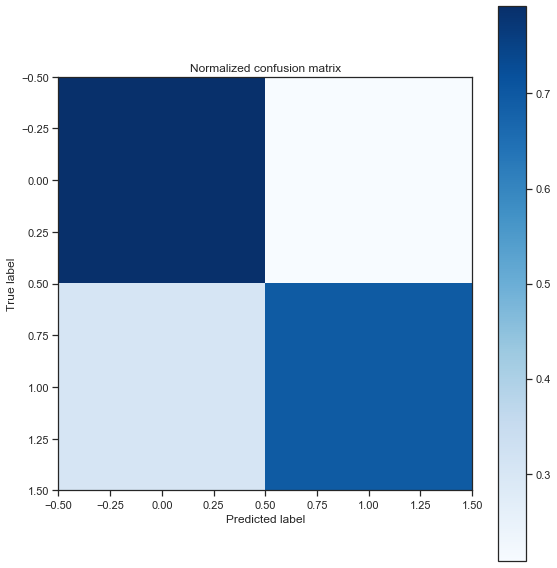

CPU times: user 2.28 s, sys: 179 ms, total: 2.46 s
Wall time: 663 ms


In [40]:
%%time
# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.show()

## 5.3 Make Prediction with the Model

Process: 
- Randomly pick a few anonymous users from the dataset.
- Randomly pick a few businesses from the dataset.
- Predict whether the user will give the business a review with five-star rating.

In [41]:
def predict_given_user_biz(user, biz, review_df):
    a_user = user.copy()
    a_biz = biz.copy()
    # The review hasn't actually be written yet.
    # XXX(xun): We fake the feature using global mean/avg values to create a "general" review. 
    #   There are many other/better ways to fake the review to be more representative
    #   (e.g. draw from the real distribution, or avg of the user / the biz). 
    a_review = pd.DataFrame(
        {
            'funny': review_df['funny'].mean(),
            'user_id': a_user.index,
            'business_id': a_biz.index,
            'useful': review_df['useful'].mean(),
            'cool': review_df['cool'].mean(),
            'date_delta': 0.0, # the review is written the most recently
            'text_len': review_df['text_len'].mean(),
        }
    )

    a_review_join_user = a_review.join(a_user, on='user_id', lsuffix='_review', rsuffix='_user')
    a_X_test = a_review_join_user.join(a_biz, on='business_id', rsuffix='_biz')

    drop_columns(df=a_X_test, columns=['user_id', 'business_id'])
    a_X_test.fillna(value=FILL_WITH, inplace=True)
    
    a_X_test_scaled = scaler.transform(a_X_test.astype(float))
    
    a_y_pred = lrc_fit.predict(a_X_test_scaled)
    a_y_pred_proba = lrc_fit.predict_proba(a_X_test_scaled)
    
    print(f'{a_y_pred[0]}, with probability [False, True] == {a_y_pred_proba[0]}')

In [42]:
user1 = user_df[user_df.index == 'kEtR1ZVL3Xr-tEX7lg16dQ']
#print(user1.review_count)
print(user1.average_stars)

user_id
kEtR1ZVL3Xr-tEX7lg16dQ    4.98
Name: average_stars, dtype: float64


In [43]:
user2 = user_df[user_df.index == 'Hj20fg3vyzKnJwnLn_rMqw']
print(user2.average_stars)

user_id
Hj20fg3vyzKnJwnLn_rMqw    4.53
Name: average_stars, dtype: float64


In [44]:
user3 = user_df[user_df.index == 'om5ZiponkpRqUNa3pVPiRg']
print(user3.average_stars)

user_id
om5ZiponkpRqUNa3pVPiRg    3.94
Name: average_stars, dtype: float64


In [45]:
biz1 = biz_df[biz_df.index == 'u-SJ5QUwrNquL9VnXwl8cg']
print(biz1.stars)

business_id
u-SJ5QUwrNquL9VnXwl8cg    4.5
Name: stars, dtype: float64


In [46]:
biz2 = biz_df[biz_df.index == 'MtUUc5w3HuDMcmL89RcG6Q']
print(biz2.stars)

business_id
MtUUc5w3HuDMcmL89RcG6Q    2.5
Name: stars, dtype: float64


## biz1: https://www.yelp.com/biz/postino-arcadia-phoenix

<img src="postino-arcadia-phoenix.png" alt="postino-arcadia-phoenix" width="800">

## biz2 https://www.yelp.com/biz/port-authority-of-allegheny-county-pittsburgh

<img src="port-authority-of-allegheny-county-pittsburgh.png" alt="port-authority-of-allegheny-county-pittsburgh" width="800">

### Make predictions for user[1,2,3]'s review on biz1

In [47]:
predict_given_user_biz(user=user1, biz=biz1, review_df=review_df)
predict_given_user_biz(user=user2, biz=biz1, review_df=review_df)
predict_given_user_biz(user=user3, biz=biz1, review_df=review_df)

True, with probability [False, True] == [0.0964155 0.9035845]
True, with probability [False, True] == [0.26828973 0.73171027]
False, with probability [False, True] == [0.68606077 0.31393923]


### Make predictions for user[1,2,3]'s review on biz2

In [48]:
predict_given_user_biz(user=user1, biz=biz2, review_df=review_df)
predict_given_user_biz(user=user2, biz=biz2, review_df=review_df)
predict_given_user_biz(user=user3, biz=biz2, review_df=review_df)

False, with probability [False, True] == [0.5291091 0.4708909]
False, with probability [False, True] == [0.79428551 0.20571449]
False, with probability [False, True] == [0.95835503 0.04164497]


# Step 6 & Beyond: Iterate Through the Process

First trial usually won’t be the best. We usually do multiple iterations. Each time we look at the features, find out feature correlations, add / remove / adjust feature representation, change the model to use, or do parameter tuning for the model, etc. 